# Getting Started with FRECKLL

The Google Colab version can be found [here](https://colab.research.google.com/drive/17qMpl1Zw8jWqb_L8s_2v7lMT9H9JT_jY?usp=sharing)

This guide is there to quickly get started on the using the `freckll` library. Here you will learn the basics:

- Loading in atmospheric data
- Loading in our network.
- Solving the atmosphere
- Plotting results
- Animating results
- Running from equilibrium
- Storing results
- Running with photochemistry.

## Loading in Atmospheric Data

First thing we need is profiles to solve. FRECKLL makes use of [astropy](https://docs.astropy.org/en/stable/) to `units` to represent data. This makes the library agnostic to units. Creating a custom profile is as simple as:

In [57]:
import numpy as np
from astropy import units as u

temperature = np.linspace(2000, 10000, 100) << u.K
pressure = np.logspace(2, -5) << u.bar

You can use your own methods to load in the data as long as it is in the form of a `Quantity` with correct units. FRECKLL includes some helpful methods to load in data under the `freckll.io.loader` module. For example, we will load in the TP profile using the `tp_profile_loader` function.

Our csv file looks like this:
```
# Pressure(mbar), Temperature (K)
0.10002E+06    1846.3
86374.        1841.7
74509.        1837.4
63753.        1836.2
54482.        1834.9
46559.        1833.4
39787.        1831.9
34001.        1830.4
29020.        1828.9
24720.        1828.1
21047.        1827.5
17919.        1826.9
```


- Column 0 is Pressure in mbar
- Column 1 is temperature in K

We can load it in using the following `tp_profile_loader` function:

In [58]:
from freckll.io.loader import tp_profile_loader

pressure, temperature = tp_profile_loader(
    filename="tpprofile.csv",
    temperature_column=1,
    temperature_unit=u.K,
    pressure_column=0,
    pressure_unit=u.mbar,
    comments="#",
)

print(pressure.shape)

(130,)


Additionally it would be nice to load in a $K_{zz}$ profile as well. We can use a loader to do this as well.

In [59]:
from freckll.io.loader import kzz_profile_loader

_pressure, kzz = kzz_profile_loader(
    filename="kzz.csv", kzz_column=1, pressure_column=0, kzz_unit=u.cm**2 / u.s, pressure_unit=u.mbar, comments="#"
)
print(kzz.shape)

(28369,)


Sometimes different profiles lie on different pressure grids, in this case $K_{zz}$ is in a much finer grid. We can get around this by interpolating the points to the TP profile grid. (Or vice-versa if you desire):

In [60]:
from freckll.utils import interpolate_pressure

kzz = interpolate_pressure(_pressure, kzz, pressure)

We can plot both profiles using the `freckll.plot` module.

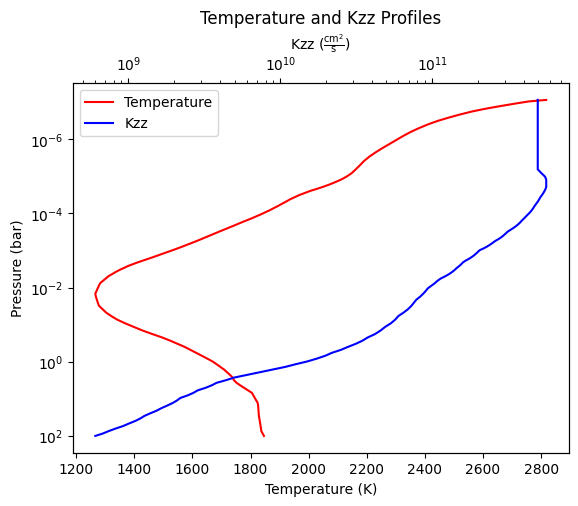

In [61]:
import matplotlib.pyplot as plt

from freckll.plot import plot_tp_and_kzz

fig, ax = plt.subplots()

plot_tp_and_kzz(pressure, temperature, kzz, ax)
plt.show()

## Loading in the Network

The next step is to load in the network. FRECKLL includes two [Venot 2020]() networks built in. The first is a full chemical network that includes photolysis and the second is a reduced network that does not include photolysis. 

You can also load in your own network but this will be covered in a different tutorial.

The `default_network_loader` allows for two arguments:
- `venot-methanol-2023-reduced` - This is the reduced network that does not include photolysis.
- `venot-methanol-2023` - This is the full network that includes photolysis.

We can use the loader to load in the reduced network:

In [ ]:
from freckll.io.loader import default_network_loader

network = default_network_loader("venot-methanol-2020-reduced")

We can inspect the species in the network:

In [63]:
network.species

[C2H3O2 (CH3OCO),
 HO2 (OOH),
 C2H3O (CH2CHO),
 C2H3O (CH3CO),
 CNO (NCO),
 CH3O (CH3O),
 O2 (O2),
 CHO2 (CO2H),
 CHNO (HOCN),
 C2H5 (C2H5),
 CH3O (CH2OH),
 C2H6 (C2H6),
 C2H3 (C2H3),
 C2H2O (CH2CO),
 HN2 (NNH),
 CH2N (H2CN),
 CH4O (CH3OH),
 CN (CN),
 CH2 (1CH2),
 CHNO (HNCO),
 O (O3P),
 C2H4 (C2H4),
 CH2 (3CH2),
 CHO (HCO),
 C2H2 (C2H2),
 CH2O (H2CO),
 H2N (NH2),
 CO2 (CO2),
 HO (OH),
 CH3 (CH3),
 CHN (HCN),
 H3N (NH3),
 CH4 (CH4),
 N2 (N2),
 CO (CO),
 H2O (H2O),
 H (H),
 He (He),
 H2 (H2),
 H2N2 (N2H2),
 H3N2 (N2H3),
 CH2N (HCNH),
 CH2O2 (HOCHO),
 CH3O2 (HOCH2O),
 H2O (H2Oc[SpeciesState.LIQUID]),
 CH4 (CH4c[SpeciesState.LIQUID]),
 H3N (NH3c[SpeciesState.LIQUID])]

The `SpeciesFormula` is a class that contains a lot of information about a particular . It includes the following attributes:
- `composition` - Number of atoms
- `mass` - Mass of the species in amu
- `state` - State of the species (gas, solid, liquid)


In [64]:
species = network.species[0]
print(f"Species name: {species}")
print(species.composition())
print(f"Mass {species.mass}")
print(f"Charge {species.charge}")
print(f"State: {species.state}")
print(f"Diffusion Volume: {species.diffusion_volume}")

Species name: CH3OCO
Element  Count  Relative mass  Fraction %
C            2      24.021480     40.6840
H            3       3.023823      5.1213
O            2      31.998810     54.1948
Mass 59.044113
Charge 0
State: SpeciesState.GAS
Diffusion Volume: 50.95


## Running reactions

We can solve for reactions given a set of conditions, we will use our tp-profile and a random mixing ratio to do this:


In [65]:
vmr = np.random.rand(len(network.species), len(pressure))
vmr = vmr / np.sum(vmr, axis=0)

reactions = network.compute_reactions(vmr, temperature, pressure)
reactions

[CH2CHO -> CH3CO (1.36e+08) (['decomposition']),
 CH3CO -> CH2CHO (4.84e+07) (['decomposition', 'inverted']),
 CH2CHO -> H + CH2CO (2.68e+09) (['decomposition']),
 H + CH2CO -> CH2CHO (1.84e-11) (['decomposition', 'inverted']),
 NNH -> N2 + H (3.00e+08) (['decomposition']),
 N2 + H -> NNH (2.06e-16) (['decomposition', 'inverted']),
 HCNH -> HCN + H (1.82e+07) (['decomposition']),
 HCN + H -> HCNH (1.40e-14) (['decomposition', 'inverted']),
 H2CN -> HCN + H (2.45e+05) (['decomposition']),
 HCN + H -> H2CN (4.69e-16) (['decomposition', 'inverted']),
 HOCH2O -> HOCHO + H (7.87e+10) (['decomposition']),
 HOCHO + H -> HOCH2O (6.18e-10) (['decomposition', 'inverted']),
 HOCHO -> CO + H2O (2.23e+06) (['decomposition']),
 CO + H2O -> HOCHO (5.44e-20) (['decomposition', 'inverted']),
 HOCHO -> CO2 + H2 (2.94e+04) (['decomposition']),
 CO2 + H2 -> HOCHO (4.36e-21) (['decomposition', 'inverted']),
 C2H3 -> C2H2 + H (2.42e+07) (['k0', 'kinf', 'falloff', 'Troe', 'decomposition']),
 C2H2 + H -> C2H3

Here each reaction is described by its `reactants`, `products`, `reaction_rate` and `dens_krate`. Where dens_krate is the reaction rate multiplied by the number density of the reactant species.

In [66]:
print(reactions[0])
print("Reaction rate:", reactions[0].reaction_rate[:10], "1/s")
print("Reaction rate:", reactions[0].dens_krate[:10], "1/cm3/s")

CH2CHO -> CH3CO (1.36e+08) (['decomposition'])
Reaction rate: [27647229.87948201 26777410.68236617 25985321.23606332 25767838.0996988
 25533968.19290701 25266348.68916494 25001102.69660493 24738213.35402364
 24477663.88574786 24339655.15159737] 1/s
Reaction rate: [3.68760286e+26 2.64777356e+26 8.51973570e+25 4.60817374e+25
 9.13701964e+25 9.46175637e+25 1.18357507e+25 8.36160909e+25
 6.93272565e+25 4.44508955e+25] 1/cm3/s


If we want to look for specific production/loss reactions for a specific species, we can add the `with_production_loss` argument.

In [67]:
reactions, (production, loss) = network.compute_reactions(vmr, temperature, pressure, with_production_loss=True)

print(production["CH4"])

[CH3 + H -> CH4 (2.61e-13) (['k0', 'kinf', 'falloff', 'Troe', 'reaction', 'inverted']), H + CH3 -> CH4 (1.39e-11) (['k0', 'kinf', 'falloff', 'Troe', 'reaction']), HOCHO + CH3 -> CH4 + CO + OH (4.91e-12) (['corps', 'reaction', 'many body']), CH3 + H2 -> CH4 + H (7.77e-13) (['corps', 'reaction', 'many body', 'inverted']), CH3 + CH3 -> CH4 + 1CH2 (1.51e-13) (['corps', 'reaction', 'many body', 'inverted']), C2H3 + CH3 -> CH4 + C2H2 (6.48e-13) (['corps', 'reaction', 'many body']), C2H4 + CH3 -> CH4 + C2H3 (1.40e-14) (['corps', 'reaction', 'many body']), C2H5 + CH3 -> C2H4 + CH4 (1.83e-12) (['corps', 'reaction', 'many body']), C2H6 + CH3 -> C2H5 + CH4 (3.96e-12) (['corps', 'reaction', 'many body']), CH3 + OH -> O3P + CH4 (4.62e-13) (['corps', 'reaction', 'many body', 'inverted']), CH3 + H2O -> OH + CH4 (5.34e-14) (['corps', 'reaction', 'many body', 'inverted']), HCO + CH3 -> CH4 + CO (1.99e-10) (['corps', 'reaction', 'many body']), CH3 + H2CO -> HCO + CH4 (1.04e-11) (['corps', 'reaction', 'm

Additionally each reaction includes a `tag` that describes some thing about the reaction. For example, we can find only reactions that use the `Troe` falloff using the `find_tagged_reactions` function.

In [68]:
from freckll.network import find_tagged_reactions

find_tagged_reactions(reactions, ["Troe"])

[C2H3 -> C2H2 + H (2.42e+07) (['k0', 'kinf', 'falloff', 'Troe', 'decomposition']),
 C2H2 + H -> C2H3 (7.56e-13) (['k0', 'kinf', 'falloff', 'Troe', 'decomposition', 'inverted']),
 C2H5 -> C2H4 + H (5.36e+07) (['k0', 'kinf', 'falloff', 'Troe', 'decomposition']),
 C2H4 + H -> C2H5 (3.69e-12) (['k0', 'kinf', 'falloff', 'Troe', 'decomposition', 'inverted']),
 CO2H -> CO + OH (4.34e+08) (['k0', 'kinf', 'falloff', 'Troe', 'decomposition']),
 CO + OH -> CO2H (3.81e-14) (['k0', 'kinf', 'falloff', 'Troe', 'decomposition', 'inverted']),
 CO2H -> CO2 + H (6.56e+07) (['k0', 'kinf', 'falloff', 'Troe', 'decomposition']),
 CO2 + H -> CO2H (1.62e-15) (['k0', 'kinf', 'falloff', 'Troe', 'decomposition', 'inverted']),
 CH3OH -> CH3 + OH (1.06e+04) (['k0', 'kinf', 'falloff', 'Troe', 'decomposition']),
 CH3 + OH -> CH3OH (4.54e-12) (['k0', 'kinf', 'falloff', 'Troe', 'decomposition', 'inverted']),
 CH3OH -> 1CH2 + H2O (2.58e+03) (['k0', 'kinf', 'falloff', 'Troe', 'decomposition']),
 1CH2 + H2O -> CH3OH (1.72

Or "Troe" and "decomposition":

In [69]:
find_tagged_reactions(reactions, ["Troe", "decomposition"])

[CH2CHO -> CH3CO (1.36e+08) (['decomposition']),
 CH3CO -> CH2CHO (4.84e+07) (['decomposition', 'inverted']),
 CH2CHO -> H + CH2CO (2.68e+09) (['decomposition']),
 H + CH2CO -> CH2CHO (1.84e-11) (['decomposition', 'inverted']),
 NNH -> N2 + H (3.00e+08) (['decomposition']),
 N2 + H -> NNH (2.06e-16) (['decomposition', 'inverted']),
 HCNH -> HCN + H (1.82e+07) (['decomposition']),
 HCN + H -> HCNH (1.40e-14) (['decomposition', 'inverted']),
 H2CN -> HCN + H (2.45e+05) (['decomposition']),
 HCN + H -> H2CN (4.69e-16) (['decomposition', 'inverted']),
 HOCH2O -> HOCHO + H (7.87e+10) (['decomposition']),
 HOCHO + H -> HOCH2O (6.18e-10) (['decomposition', 'inverted']),
 HOCHO -> CO + H2O (2.23e+06) (['decomposition']),
 CO + H2O -> HOCHO (5.44e-20) (['decomposition', 'inverted']),
 HOCHO -> CO2 + H2 (2.94e+04) (['decomposition']),
 CO2 + H2 -> HOCHO (4.36e-21) (['decomposition', 'inverted']),
 C2H3 -> C2H2 + H (2.42e+07) (['k0', 'kinf', 'falloff', 'Troe', 'decomposition']),
 C2H2 + H -> C2H3

For performance reactions can also be precompiled to a specific temperature/pressure profile. Compare this:

In [70]:
%timeit network.compute_reactions(vmr, temperature, pressure)

19.2 ms ± 247 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


With this:

In [71]:
network.compile_reactions(temperature, pressure)

%timeit network.compute_reactions(vmr)

8.81 ms ± 135 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


A 50% decrease in runtime!

## Solving the atmosphere

We now want to solve the atmosphere. We require a solver to accomplish this. FRECKLL supports two solvers:

- VODE
- Rosenbrock

For the purpose of this tutorial we will use the Rosenbrock solver. We can import our solver from `freckll.solver` and create a solver object. The solver object requires the following arguments:
- `network` - The network object
- `photochemistry` - A photochemistry object. This is not required if you are not using photochemistry. (We will cover this later).

In [72]:
from freckll.solver import Rosenbrock

rosen = Rosenbrock(network=network)

Before we can solve the atmosphere we need to setup the conditions of the atmosphere. This includes the temperature, vmr, planetary parameters and so on. This can be done using the `set_system_parameters` method

In [73]:
rosen.set_system_parameters(
    temperature=temperature,
    pressure=pressure,
    kzz=kzz,
    planet_radius=1.37 * u.Rjup,
    planet_mass=0.87 << u.Mjup,
)

The solver will automatically compile the networks for us so there is no need to `precompile` them beforehand.
Finally we now solve our atmosphere. We will use a randomized initial mixing ratio. 

This should take no more than 20-30 seconds to run. The solver will return a `SolverResult` dictionary that contains the results of the simulation. 
This includes the following attributes:
- `success` - A boolean that indicates if the simulation was successful
- `times` - The time points of the simulation
- `vmr` - The volume mixing ratio of the species at each time point
- `initial_vmr` - The initial volume mixing ratio of the species
- `temperature` - The temperature of the atmosphere
- `pressure` - The pressure of the atmosphere
- `density` - The density of the atmosphere
- `kzz` - The eddy diffusion coefficient
- `planet` - Planet parameters
- `species` - The species in the network

In [74]:
vmr = np.random.rand(len(network.species), len(pressure))
vmr = vmr / np.sum(vmr, axis=0, keepdims=True)


result = rosen.solve(
    vmr=vmr,
    t_span=[0, 1e16],
    enable_diffusion=False,
    maxiter=1000,
)

print("Success:", result["success"])

Success: True


We have lots of plotting options available for us. Plotting the initial and steady state:

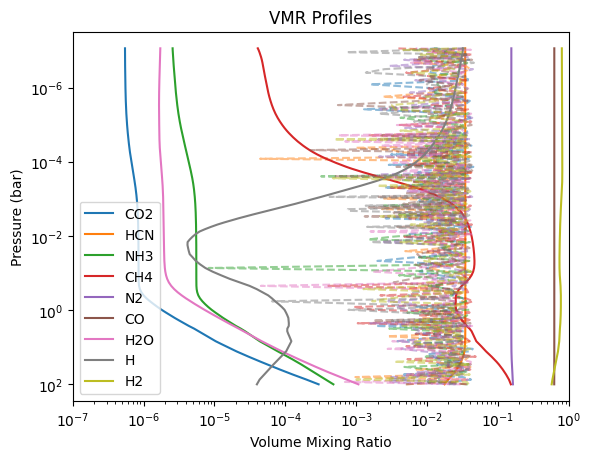

In [19]:
from freckll.plot import plot_vmr

fig, ax = plt.subplots()
plot_vmr(
    result["vmr"][-1],
    result["pressure"],
    result["species"],
    initial_vmr=result["initial_vmr"],
    xlims=(1e-7, 1e0),
    ax=ax,
)
plt.show()

The dashed lines are our initial conditions and the solid are the final solved state.
We can also animate the results as well:

In [42]:
from IPython.display import Video

In [43]:
%%capture
from freckll.plot import animate_vmr

fig, ax = plt.subplots()

anim = animate_vmr(
    vmrs=result["vmr"],
    times=result["times"],
    species=result["species"],
    pressure=result["pressure"],
    initial_vmr=result["initial_vmr"],
    xlims=(1e-7, 1e0),
    blit=True,
    repeat=False,
    interval=50,
)

anim.save("randomvmr.mp4", fps=30, dpi=200, writer="ffmpeg")

In [44]:
Video("randomvmr.mp4")

# Running from Equilibrium

Of course we may want to start from an atmosphere of given metallicity and molecular ratios. You can supply your own initial VMR as along as the first dimension maps
to each species in `network.species`. The solver will then run from this initial VMR to the final state.

`FRECKLL` includes the equilibrium code `ACE` which is installed either from:
```bash
pip install freckll[ace]
```
or
```bash
pip install freckll[recommended]
```
or you can install it manually using:
```bash
pip install acepython
```

Under `freckll.ace` you can use `equil_chemistry_ace` and abundance ratios to solve for the equilibrium state of the atmosphere.


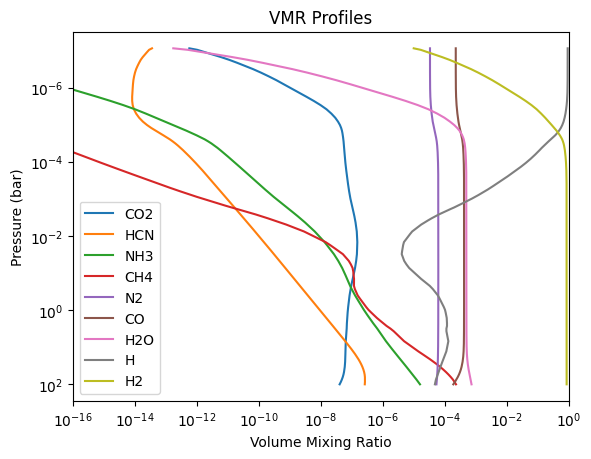

In [75]:
from freckll.ace import equil_chemistry_ace

equil_vmr = equil_chemistry_ace(
    temperature=temperature,
    pressure=pressure,
    composition=network.species,
    elements=["H", "He", "C", "N", "O"],
    abundances=[12, 10.93, 8.39, 7.86, 8.73],
)

fig, ax = plt.subplots()
plot_vmr(
    equil_vmr,
    pressure,
    network.species,
    ax=ax,
)
plt.show()

Lets solve using this mixing ratio instead!

In [76]:
result_equil = rosen.solve(
    vmr=equil_vmr,
    t_span=[0, 1e16],
    enable_diffusion=False,
    maxiter=1000,
)
print("Success:", result_equil["success"])

Success: True


Now lets plot the initial and final mixing ratios:

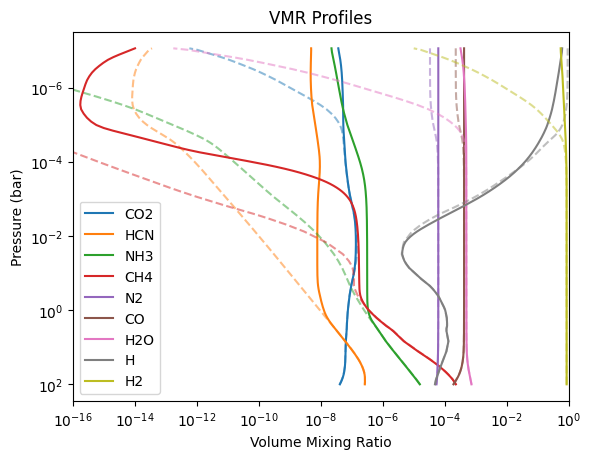

In [77]:
fig, ax = plt.subplots()
plot_vmr(
    result_equil["vmr"][-1],
    result_equil["pressure"],
    result_equil["species"],
    initial_vmr=result_equil["initial_vmr"],
    xlims=(1e-16, 1e0),
    ax=ax,
)
plt.show()

Nice! Lets also animate the result!

In [45]:
%%capture

anim_equil = animate_vmr(
    vmrs=result_equil["vmr"],
    times=result_equil["times"],
    species=result_equil["species"],
    pressure=result_equil["pressure"],
    initial_vmr=result_equil["initial_vmr"],
    xlims=(1e-16, 1e0),
    blit=True,
    repeat=False,
    interval=50,
)

anim_equil.save("equil_vmr.mp4", fps=30, dpi=200, writer="ffmpeg")

In [ ]:
Video("equil_vmr.mp4")

# Storing and Reading Results

We can store the output of a solution to HDF5 format using the `freckll.io.output` modules. We can simply takes the result from the solver and run this function:

In [99]:
from freckll.io.output import write_solution_h5py

write_solution_h5py(
    solution=result_equil,
    filename="solution_equil.h5",
    overwrite=True,
)

In [98]:
result_equil["kzz"].to(u.km**2 / u.s)

<Quantity [ 0.060581,  0.067763,  0.074008,  0.081942,  0.091984,
            0.10057 ,  0.11062 ,  0.11959 ,  0.12731 ,  0.13889 ,
            0.15285 ,  0.16473 ,  0.17998 ,  0.19574 ,  0.2089  ,
            0.22018 ,  0.24598 ,  0.26802 ,  0.28646 ,  0.32172 ,
            0.35312 ,  0.38089 ,  0.43848 ,  0.49786 ,  0.60296 ,
            0.73518 ,  0.89028 ,  1.0804  ,  1.2702  ,  1.5116  ,
            1.7425  ,  1.9822  ,  2.1817  ,  2.5009  ,  2.7803  ,
            3.1297  ,  3.4672  ,  3.7621  ,  4.2081  ,  4.5792  ,
            4.8991  ,  5.3512  ,  5.7117  ,  5.9925  ,  6.4878  ,
            6.938   ,  7.2997  ,  7.5706  ,  7.8635  ,  8.3343  ,
            8.7289  ,  9.0578  ,  9.3517  ,  9.873   , 10.428   ,
           10.839   , 11.392   , 12.223   , 12.922   , 13.528   ,
           14.055   , 14.505   , 15.063   , 15.52    , 15.931   ,
           16.548   , 17.366   , 18.115   , 18.802   , 19.404   ,
           19.941   , 20.518   , 21.776   , 22.909   , 23.962   ,
          

If we want to restore it, it is as easy as running the read function:

In [100]:
from freckll.io.output import read_h5py_solution

solution_h5 = read_h5py_solution("solution_equil.h5")

In [101]:
solution_h5["kzz"].to(u.km**2 / u.s)

<Quantity [ 0.060581,  0.067763,  0.074008,  0.081942,  0.091984,
            0.10057 ,  0.11062 ,  0.11959 ,  0.12731 ,  0.13889 ,
            0.15285 ,  0.16473 ,  0.17998 ,  0.19574 ,  0.2089  ,
            0.22018 ,  0.24598 ,  0.26802 ,  0.28646 ,  0.32172 ,
            0.35312 ,  0.38089 ,  0.43848 ,  0.49786 ,  0.60296 ,
            0.73518 ,  0.89028 ,  1.0804  ,  1.2702  ,  1.5116  ,
            1.7425  ,  1.9822  ,  2.1817  ,  2.5009  ,  2.7803  ,
            3.1297  ,  3.4672  ,  3.7621  ,  4.2081  ,  4.5792  ,
            4.8991  ,  5.3512  ,  5.7117  ,  5.9925  ,  6.4878  ,
            6.938   ,  7.2997  ,  7.5706  ,  7.8635  ,  8.3343  ,
            8.7289  ,  9.0578  ,  9.3517  ,  9.873   , 10.428   ,
           10.839   , 11.392   , 12.223   , 12.922   , 13.528   ,
           14.055   , 14.505   , 15.063   , 15.52    , 15.931   ,
           16.548   , 17.366   , 18.115   , 18.802   , 19.404   ,
           19.941   , 20.518   , 21.776   , 22.909   , 23.962   ,
          

And we can replot it to prove it is the same:

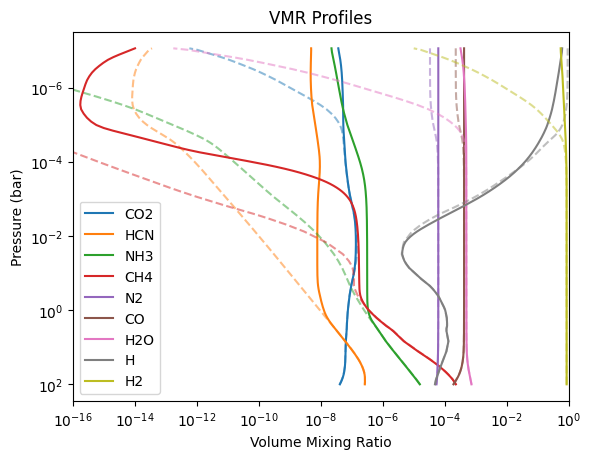

In [78]:
fig, ax = plt.subplots()
plot_vmr(
    solution_h5["vmr"][-1],
    solution_h5["pressure"],
    solution_h5["species"],
    initial_vmr=solution_h5["initial_vmr"],
    xlims=(1e-16, 1e0),
    ax=ax,
)
plt.show()

# Running with Photochemistry

For the photochemistry case we will need to use the full network instead. We can load it in using the `default_network_loader` function:


In [ ]:
full_network = default_network_loader("venot-methanol-2020")

We will also need to load in the photochemistry and actinic flux for the star. This is easily accomplished using the loader modules.
We will load the Venot 2020 photochemistry and the actinic flux for HD 209458 star

In [80]:
from freckll.io.loader import default_photonetwork_loader, default_stellar_spectra_loader

photo_network = default_photonetwork_loader(full_network.species)
stellar_spectra = default_stellar_spectra_loader("hd209458")

Lets plot the stellar flux and see what it looks like!

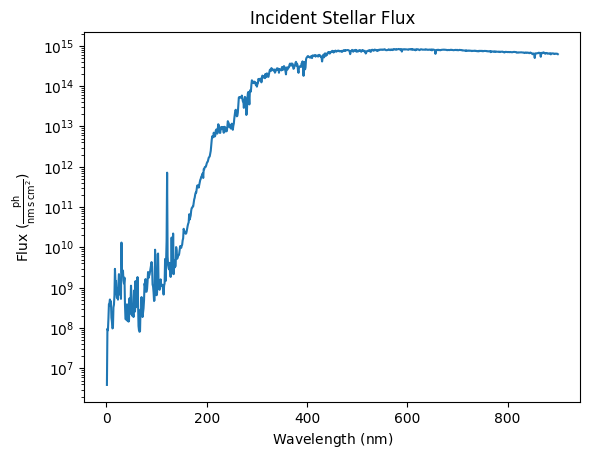

In [81]:
from freckll.plot import plot_stellar_flux

fig, ax = plt.subplots()
plot_stellar_flux(stellar_spectra.flux, stellar_spectra.wavelength, ax=ax)
plt.show()

We can now build a new solver with the photochemistry included. The photochemistry object is passed to the solver as an argument.

In [82]:
rosenbrock_photo = Rosenbrock(
    network=full_network,
    photochemistry=photo_network,
)

Now we can setup the photoparameters and the system parameters like so:

In [83]:
photo_network.set_spectra(stellar_spectra, distance=0.047 << u.AU, albedo=0.0)
rosenbrock_photo.set_system_parameters(
    temperature=temperature,
    pressure=pressure,
    kzz=kzz,
    planet_radius=1.37 * u.Rjup,
    planet_mass=0.87 << u.Mjup,
)

Lets generate our new equilibrium state:


In [84]:
vmr_photo_equil = equil_chemistry_ace(
    temperature=temperature,
    pressure=pressure,
    composition=full_network.species,
    elements=["H", "He", "C", "N", "O"],
    abundances=[12, 10.93, 8.39, 7.86, 8.73],
)

Now let us solve! This will take a little longer ~ 40 seconds to a minute:

In [85]:
result_photo_equil = rosenbrock_photo.solve(
    vmr=vmr_photo_equil,
    t_span=[0, 1e20],
    enable_diffusion=False,
    maxiter=1000,
)
print("Success:", result_photo_equil["success"])

/Users/ahmed/Documents/repos/FRECKLL/.venv/lib/python3.12/site-packages/astropy/units/quantity.py:658: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/ahmed/Documents/repos/FRECKLL/.venv/lib/python3.12/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/ahmed/Documents/repos/FRECKLL/.venv/lib/python3.12/site-packages/astropy/units/quantity.py:658: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Success: True


Lets plot the results!

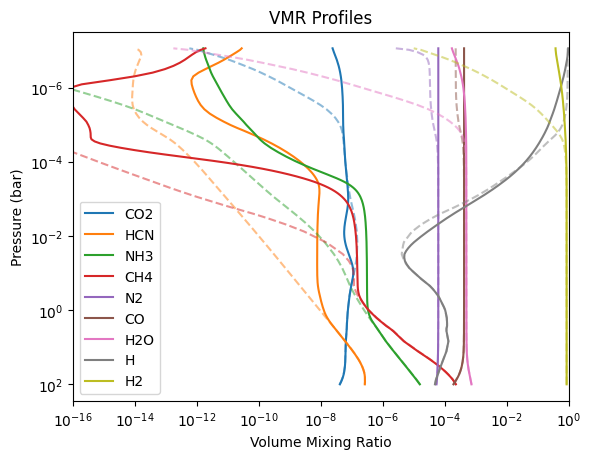

In [86]:
fig, ax = plt.subplots()
plot_vmr(
    result_photo_equil["vmr"][-1],
    result_photo_equil["pressure"],
    result_photo_equil["species"],
    initial_vmr=result_photo_equil["initial_vmr"],
    xlims=(1e-16, 1e0),
    ax=ax,
)
plt.show()

And lets animate it!

In [55]:
%%capture

anim_photo_equil = animate_vmr(
    vmrs=result_photo_equil["vmr"],
    times=result_photo_equil["times"],
    species=result_photo_equil["species"],
    pressure=result_photo_equil["pressure"],
    initial_vmr=result_photo_equil["initial_vmr"],
    xlims=(1e-16, 1e0),
    blit=True,
    repeat=False,
    interval=50,
)

anim_photo_equil.save("photo_equil_vmr.mp4", fps=30, dpi=200, writer="ffmpeg")

In [ ]:
Video("photo_equil_vmr.mp4")

Thats all there is to it! Try it and see what you can solve!